In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import svm
from scipy.stats import poisson, binom

In [2]:
# Generate training data for sales probability regression
def rank(a, p):
    _rank = p.shape[0]
    for i in range(p.shape[0]):
        if a < p[i]:
            _rank = _rank - 1
    return _rank

# def make_X(price, competitor_prices, t):
#     return np.array([
#             1,
#             rank(price, competitor_prices),
#             price - competitor_prices.min(),
#             competitor_prices.size,
#             (price + np.sum(competitor_prices)) / (1 + competitor_prices.size),
#             t * t
#         ])

def make_X(price, competitor_prices, t):
    return np.hstack((competitor_prices, np.array([price, t])))


def generate_train_data(B=1000, T=30):
    our_price = np.around(10 + np.random.uniform(0, 10, (B, 1)), decimals=2)
    competitor_prices = np.around(10 + np.random.uniform(0, 10, (B, 5)), decimals=2)
    
    X = np.zeros((B, 7))
    Y = np.zeros(B)
    for t in range(T):
        for i in range(B):
            X[i,:] = make_X(our_price[i], competitor_prices[i], t)
            _rank = rank(our_price[i], competitor_prices[i])
            # Y[i] = _rank == 0
            Y[i] = np.round(np.random.uniform( t / (2 * T), 1) * (1 - _rank / 5))

    
    return (X, Y)

X, Y = generate_train_data()

In [3]:
# Train sales probability model
def make_model(X, Y):
    regr = linear_model.LogisticRegression()
    regr.fit(X, Y)
    def predict(x):
        # return np.maximum(0, regr.predict(x))
        return regr.predict_proba(x)[:, 1]
    return predict

sales_model = make_model(X, Y)

In [4]:
# Plot sales probability model
# X_train, _ = generate_train_data(1000)
# X_sort = np.sort(X_train.view('f8,f8,f8,f8,f8,f8'), order=['f1'], axis=0).view(float)
# plt.scatter(np.arange(0, X_sort.shape[0]), X_sort[:, 1], color='black')
# plt.plot(np.arange(0, X_sort.shape[0]), sales_model(X_sort), color='blue', linewidth=1)

# plt.show()

In [5]:
def sales_prob(price, t, options):
    x = make_X(price, competitor_prices, t).reshape(1, -1)
    return options.sales_model(x)[0]


def _V(price, t, n, options):
    p = sales_prob(price, t, options)
    _sum = 0
    for i in range(int(poisson.ppf(0.9999, options.M * p)) + 1):
    # for i in range(int(binom.ppf(0.9999, options.M, p)) + 1):
        if i > n:
            return 0
        pi = poisson.pmf(i, options.M * p)
        # pi = binom.pmf(i, options.M, p)
        today_profit = min(n, i) * price
        holding_costs = n * options.L
        _, V_future = V(t + 1, max(0, n - i), options)
        exp_future_profits = options.delta * V_future
        _sum += pi * (today_profit - holding_costs + exp_future_profits)
    return _sum

def V(t, n, options):
    if (t,n) in options.cache:
        return options.cache[t,n]
    if t >= options.T:
        options.cache[t,n] = (0, n * options.Z)
        return (0, n * options.Z)
    if n <= 0:
        options.cache[t,n] = (0, 0)
        return (0, 0)

    V_opt = -100000
    price_opt = -100000
    for price in options.price_range:
        v = _V(price, t, n, options)
        if v > V_opt:
            V_opt = v
            price_opt = price
            
    options.cache[t,n] = (price_opt, V_opt)
    return (price_opt, V_opt)


class PriceOptimizer():
    def __init__(self, sales_model, competitor_prices,
               T=20, N=15, M=5,
               price_range=np.arange(10, 20, 1), 
               L=0.01, delta=0.99, Z=0.5):
        self.sales_model = sales_model
        self.competitor_prices = competitor_prices
        self.T = T # max. time intervals
        self.N = N # max. items
        self.M = M # reference items sold per interval
        self.price_range = price_range # acceptable price range
        self.L = L # holding cost per item
        self.delta = delta # discount factor for future sales
        self.Z = Z # salvage profits
        self.cache = {}

    def run(self, t, n):
        if len(self.cache) == 0:
            res = V(t, n, self)
            for i_n in range(1, self.N + 1):
                n_data = []
                for i_t in range(1, self.T + 1):
                    if(i_t, i_n) in self.cache:
                        n_data.append(self.cache[i_t, i_n][0])
                    else:
                        n_data.append(None)
                if(i_n % 4 == 0):
                    label_text = "N=" + str(i_n)
                    plt.plot(n_data, label=label_text)    
            plt.ylabel('n')
            plt.xlabel('t')
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            plt.show()       
            return res
        else:
            return V(t, n, self)

In [ ]:
def simulation(sales_model, competitor_prices, T=20, N=15):
    
    def sales_prob(price, t):
        x = make_X(price, competitor_prices, t).reshape(1, -1)
        return sales_model(x)[0]
   
    price_history = []
    accumulated_sales = []
    
    profit = 0
    n = N
    L=0.01
    Z=0.5
    M=2

    optimizer = PriceOptimizer(sales_model, competitor_prices, 
                               N=N, T=T, L=L, Z=Z, M=M, price_range=np.arange(10, 20, 0.2))
    
    for t in range(0, T):
        price, V = optimizer.run(t, n)
        pi = sales_prob(price, t)
        sales = min(n, np.random.poisson(M * pi))
        # sales = min(n, np.random.binomial(M, pi))
        n = n - sales
        profit += price * sales - L * n
        
        price_history.append(price)
        accumulated_sales.append(N - n)
        
        # # Change competitor prices
        # competitor_prices = competitor_prices * np.random.uniform(0.8, 1.2, 5)
        # optimizer = PriceOptimizer(sales_model, competitor_prices, N=n, T=T, L=L, Z=Z)
    
    # Realize salvage profits
    profit += n * Z
    print("Estimated profit: {0}".format(optimizer.run(0, N)[1]))
    print("Simulated profit: {0}".format(profit))
    
    plt.plot(price_history)    
    plt.ylabel('Price Path')
    plt.show()
    
    plt.plot(accumulated_sales)    
    plt.ylabel('Accumulated Sales')
    plt.show()

    return profit

# competitor_prices_simulation = 16 + np.random.uniform(0, 4, 5)
# simulation(sales_model, competitor_prices_simulation)

[11 13 14 16 18]


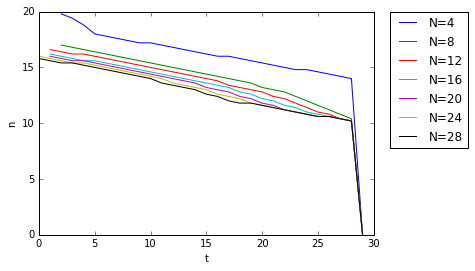

Estimated profit: 385.61069718577517
Simulated profit: 428.8699999999995


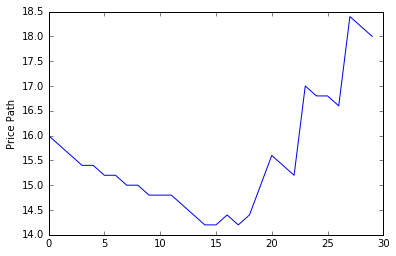

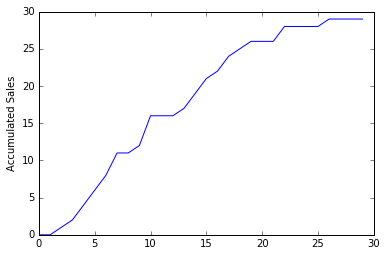

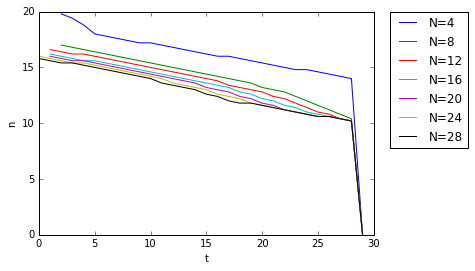

Estimated profit: 385.61069718577517
Simulated profit: 408.6099999999996


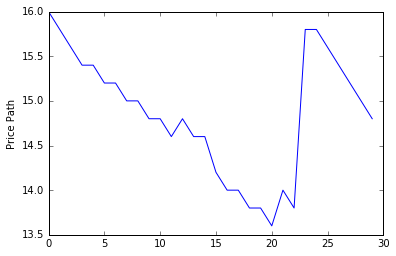

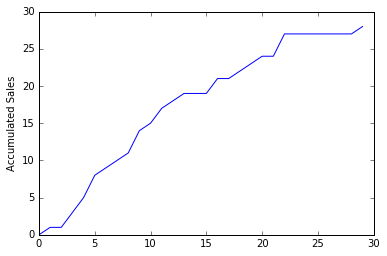

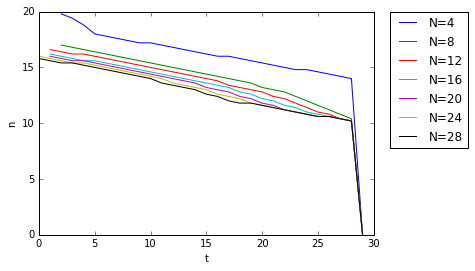

Estimated profit: 385.61069718577517
Simulated profit: 426.9999999999996


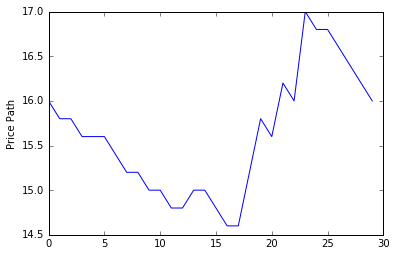

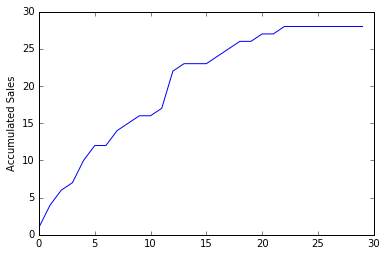

In [ ]:
# competitor_prices = np.around(10 + np.random.uniform(0, 10, 5), decimals=2)
competitor_prices = np.array([11, 13, 14, 16, 18])
print(competitor_prices)
profits = [simulation(sales_model, competitor_prices, T=30, N=30) for i in range(0, 10)]
    
n, bins, patches = plt.hist(profits, 10, normed=1, facecolor='green', alpha=0.75)

plt.xlabel('Profit')
plt.ylabel('Probability')
plt.show()